In [39]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler

In [40]:
## Test Data
fake_test_data = pd.read_csv('./Data/test.csv')

In [41]:
fake_test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [42]:
## create dataset
fake_news_df = pd.read_csv('./Data/train.csv')

In [43]:
fake_news_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


In [44]:
## Merge data for new column

fake_news_df["merged"] = fake_news_df["title"]+" "+fake_news_df["author"]

fake_news_df.head()

,id,title,author,text,label,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1,Iranian woman jailed for fictional unpublished...


In [45]:
#  check null values
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
merged    2515
dtype: int64

In [46]:
# drop null values
fake_news_df=fake_news_df.dropna()

In [47]:
# Now count the Unique values using np.unique to find the elements of an array as parameter
count = np.unique(fake_news_df['label'], return_counts=True)
print(count)

(array([0, 1], dtype=int64), array([10361,  7924], dtype=int64))


<AxesSubplot:xlabel='label', ylabel='count'>

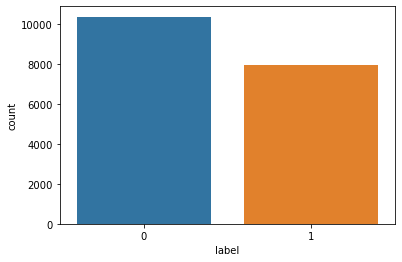

In [48]:
import seaborn as sns
sns.countplot(x='label', data = fake_news_df)

In [49]:
# Dependent Features
Y = fake_news_df['label']

# Independent Features
X = fake_news_df.drop('label', axis=1)

In [50]:
# change the dataset into numerical representation
# make the copy of Dependent Featues and reset the index because we drop the nan values due to this 
# the index is disturb
messages = X.copy()
# messages.reset_index(inplace=True)

In [51]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [52]:
messages.reset_index(inplace=True)

In [53]:
# Data processing
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vida_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [55]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['merged'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [56]:
corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [57]:
voc_size = 5000
onehot_repre = [one_hot(words, voc_size) for words in corpus]
onehot_repre[0]

[814, 1326, 2683, 2066, 4090, 2770, 2126, 4876, 4051, 3142, 2271, 1363]

In [58]:
# Word embedding
sent_length = 20
embedded_docs = pad_sequences(onehot_repre, padding='pre', maxlen=sent_length)
print(embedded_docs[0])

[   0    0    0    0    0    0    0    0  814 1326 2683 2066 4090 2770
 2126 4876 4051 3142 2271 1363]


In [59]:
## CREATING A MODEL

In [60]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
x_final = np.array(embedded_docs)
y_final = np.array(Y)

In [62]:
x_final.shape, y_final.shape

((18285, 20), (18285,))

In [63]:
## SPLIT THE DATA INTO TRAIN AND TEST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42)

In [64]:
# MODEL TRAINING
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)


Epoch 1/20
258/258 [==============================] - 7s 20ms/step - loss: 0.1979 - accuracy: 0.9116 - val_loss: 0.0431 - val_accuracy: 0.9891
Epoch 2/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0254 - accuracy: 0.9924 - val_loss: 0.0209 - val_accuracy: 0.9940
Epoch 3/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.0190 - val_accuracy: 0.9951
Epoch 4/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0258 - val_accuracy: 0.9934
Epoch 5/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0219 - val_accuracy: 0.9945
Epoch 6/20
258/258 [==============================] - 5s 18ms/step - loss: 8.8051e-04 - accuracy: 0.9999 - val_loss: 0.0276 - val_accuracy: 0.9923
Epoch 7/20
258/258 [==============================] - 5s 18ms/step - loss: 0.0088 - accuracy: 0.9980 - val_loss: 0.0199 - val_accuracy: 0.

In [65]:
# PERFORMANCE METRICS AND ACCURACY
classes_x = (model.predict(X_test) > 0.5).astype("int32")

58/58 [==============================] - 1s 5ms/step


In [66]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[1033,    3],
       [   7,  786]], dtype=int64)

In [67]:
#Accuracy Score
from sklearn.metrics import accuracy_score
score_0 = accuracy_score(y_test,classes_x)
print(score_0)

0.9945325314379442


In [71]:
model_1 = LogisticRegression(max_iter=900)
model_1.fit_resample(X_train,y_train)
pred_1 = model_1.predict(X_test)
# cr1    = classification_report(y_test,pred_1)
# print(cr1)
score_1 = accuracy_score(y_test,pred_1)
print(score_1)

0.7184253690541279


In [83]:
# Resample the training data with the RandomOversampler
#from imblearn.over_sampling import RandomOverSampler

model_3 = RandomOverSampler(random_state=1)
model_3.fit(X_train,y_train)
pred_3 = model_3.predict(X_test)
# cr3    = classification_report(y_test,pred_3)
# print(cr3)
score_3 = accuracy_score(y_test,pred_3)
print(score_3)

AttributeError: 'RandomOverSampler' object has no attribute 'predict'

In [79]:
model_4 = RandomForestClassifier()
model_4.fit(X_train,y_train)
pred_4 = model_4.predict(X_test)
# cr4    = classification_report(y_test,pred_4)
# print(cr4)
score_4 = accuracy_score(y_test,pred_4)
print(score_4)

0.9081465281574631


In [75]:
from imblearn.under_sampling import ClusterCentroids

model_5 = ClusterCentroids()
model_5.fit(X_train,y_train)
pred_5 = model_5.predict(X_test)
# cr5    = classification_report(y_test,pred_5)
# print(cr5)
score_5 = accuracy_score(y_test,pred_5)
print(score_5)

AttributeError: 'ClusterCentroids' object has no attribute 'predict'

In [38]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN

model_6 = SMOTEENN()
model_6.fit(X_train,y_train)
pred_6 = model_6.predict(X_test)
# cr6    = classification_report(y_test,pred_6)
# print(cr6)
score_6 = accuracy_score(y_test,pred_6)

AttributeError: 'SMOTEENN' object has no attribute 'predict'